<a href="https://colab.research.google.com/github/giankev/wikidata_cultural_classifier/blob/main/notebooks/stacked_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
URL_FILE_1 = "https://raw.githubusercontent.com/giankev/wikidata_cultural_classifier/refs/heads/main/dataset_parser.py"
URL_FILE_2 = "https://raw.githubusercontent.com/giankev/wikidata_cultural_classifier/refs/heads/main/wiki_extractor.py"
URL_FILE_3 = "https://raw.githubusercontent.com/giankev/wikidata_cultural_classifier/refs/heads/main/custom_dataset.py"

print("Scaricando il file 1...")
!wget {URL_FILE_1}

print("\nScaricando il file 2...")
!wget {URL_FILE_2}

print("\nScaricando il file 3...")
!wget {URL_FILE_3}

print("\nDownload completati. Contenuto della directory corrente:")

Scaricando il file 1...
--2025-05-02 12:30:21--  https://raw.githubusercontent.com/giankev/wikidata_cultural_classifier/refs/heads/main/dataset_parser.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9788 (9.6K) [text/plain]
Saving to: ‘dataset_parser.py’

dataset_parser.py   100%[===================>]   9.56K  --.-KB/s    in 0s      

2025-05-02 12:30:21 (84.0 MB/s) - ‘dataset_parser.py’ saved [9788/9788]


Scaricando il file 2...
--2025-05-02 12:30:21--  https://raw.githubusercontent.com/giankev/wikidata_cultural_classifier/refs/heads/main/wiki_extractor.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.11

In [1]:
!pip install wikidata

In [82]:
from custom_dataset import CustomData
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
'''
per salvare il dataset di training processato in un file csv,
senza dover ogni volta ripetere il procedimento
'''

PROCESSED_TRAIN_CSV = 'train_processed.csv'
PROCESSED_VAL_CSV = 'validation_processed.csv'

# --- Flag per Forzare Ricalcolo ---
FORCE_REPROCESS = False # Imposta a True per ignorare i CSV e rifare tutto
df_train_processed = None

if not FORCE_REPROCESS and os.path.exists(PROCESSED_TRAIN_CSV):
    print(f"Caricando training data processato da {PROCESSED_TRAIN_CSV}...")
    try:
        df_train_processed = pd.read_csv(PROCESSED_TRAIN_CSV)
        print("Caricamento training completato.")
    except Exception as e:
        print(f"Errore caricamento {PROCESSED_TRAIN_CSV}, ricalcolo: {e}")
        df_train_processed = None # Forza ricalcolo

if df_train_processed is None:
    print("Processing training data...")
    try:
        df_train_raw = pd.read_csv('train.csv')
        processor_train = CustomData(df_train_raw)
        df_train_featured = processor_train.add_feature()
        if df_train_featured is not None:
             df_train_processed = processor_train.preprocess_data(df_train_featured) # Applica preprocess

             if df_train_processed is not None:
                  df_train_processed.to_csv(PROCESSED_TRAIN_CSV, index=False) # Salva
                  print(f"Training data processato e salvato in {PROCESSED_TRAIN_CSV}.")
             else:
                  print("ATTENZIONE: Training data non salvato.")
        else:
             print("ERRORE: Aggiunta features fallita per training set.")

    except Exception as e:
        print(f"ERRORE durante processing training data: {e}")
        df_train_processed = None

df_val_processed = None
if not FORCE_REPROCESS and os.path.exists(PROCESSED_VAL_CSV):
    print(f"\nCaricando validation data processato da {PROCESSED_VAL_CSV}...")
    try:
        df_val_processed = pd.read_csv(PROCESSED_VAL_CSV)
        print("Caricamento validation completato.")
    except Exception as e:
        print(f"Errore caricamento {PROCESSED_VAL_CSV}, ricalcolo: {e}")
        df_val_processed = None

if df_val_processed is None:
    print("\nProcessing validation data...")
    try:
        df_val_raw = pd.read_csv('valid.csv')
        processor_val = CustomData(df_val_raw)
        df_val_featured = processor_val.add_feature()
        if df_val_featured is not None:
            df_val_processed = processor_val.preprocess_data(df_val_featured)

            if df_val_processed is not None:
                df_val_processed.to_csv(PROCESSED_VAL_CSV, index=False) # Salva
                print(f"Validation data processato e salvato in {PROCESSED_VAL_CSV}.")
            else:
                 print("ATTENZIONE: Validation data processato è vuoto o None, non salvato.")

        else:
            print("ERRORE: Aggiunta features fallita per validation set.")

    except Exception as e:
        print(f"ERRORE durante processing validation data: {e}")
        df_val_processed = None

if df_train_processed is not None and df_val_processed is not None:
    print("\n--- Dati Pronti (Preliminare) ---")
    print(f"Train shape: {df_train_processed.shape}")
    print(f"Validation shape: {df_val_processed.shape}")
else:
    print("\nErrore: Impossibile ottenere entrambi i set di dati processati.")

Caricando training data processato da train_processed.csv...
Caricamento training completato.

Caricando validation data processato da validation_processed.csv...
Caricamento validation completato.

--- Dati Pronti (Preliminare) ---
Train shape: (6249, 33)
Validation shape: (300, 33)


In [3]:
X_train = df_train_processed.drop(columns=["label"])
y_train = df_train_processed["label"]

X_val = df_val_processed.drop(columns=['label'])
y_val = df_val_processed['label']

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_val = X_val.apply(pd.to_numeric, errors='coerce')

print("Shape prima dello scaling:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")

Shape prima dello scaling:
  X_train: (6249, 32)
  X_val:   (300, 32)


In [4]:
X_train.columns.tolist()

['type',
 'number_sitelinks',
 'sitelinks_translation_entropy',
 'number_claims',
 'po_P495',
 'po_P1343',
 'po_P2596',
 'po_P17',
 'number_of_P31',
 'sum_cultural_claims',
 'po_P172',
 'po_P1268',
 'po_P136',
 'category_architecture',
 'category_biology',
 'category_books',
 'category_comics and anime',
 'category_fashion',
 'category_films',
 'category_food',
 'category_geography',
 'category_gestures and habits',
 'category_history',
 'category_literature',
 'category_media',
 'category_music',
 'category_performing arts',
 'category_philosophy and religion',
 'category_politics',
 'category_sports',
 'category_transportation',
 'category_visual arts']

In [5]:
label_mapping = {
    'cultural agnostic': 0,
    'cultural representative': 1,
    'cultural exclusive': 2
}

y_train = y_train.map(label_mapping)
y_val= y_val.map(label_mapping)

In [6]:
print("\n--- Ispezione Valori Unici in y ---")
print("Valori unici in y_train:", y_train.unique())
print("Conteggio valori in y_train:\n", y_train.value_counts())

print("\nValori unici in y_val:", y_val.unique())
print("Conteggio valori in y_val:\n", y_val.value_counts())
print("-" * 30)


--- Ispezione Valori Unici in y ---
Valori unici in y_train: [2 1 0]
Conteggio valori in y_train:
 label
2    2690
0    1871
1    1688
Name: count, dtype: int64

Valori unici in y_val: [1 2 0]
Conteggio valori in y_val:
 label
0    117
1    107
2     76
Name: count, dtype: int64
------------------------------


Starting training and grid search...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 250, 'subsample': 0.8}
Final dev set metrics: {'accuracy': np.float64(0.7566666666666667), 'precision': 0.7515198639168202, 'recall': 0.7531744730465832, 'f1': 0.7473960068929939}
                         precision    recall  f1-score   support

      cultural agnostic       0.78      0.89      0.83       117
cultural representative       0.77      0.61      0.68       107
     cultural exclusive       0.70      0.76      0.73        76

               accuracy                           0.76       300
              macro avg       0.75      0.75      0.75       300
           weighted avg       0.76      0.76      0.75       300


✅ Ultra Stacking Mode Completed!


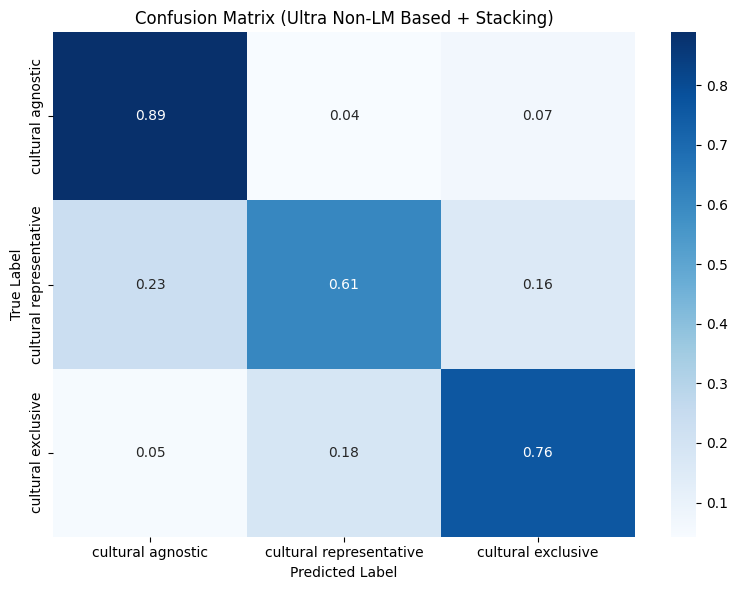

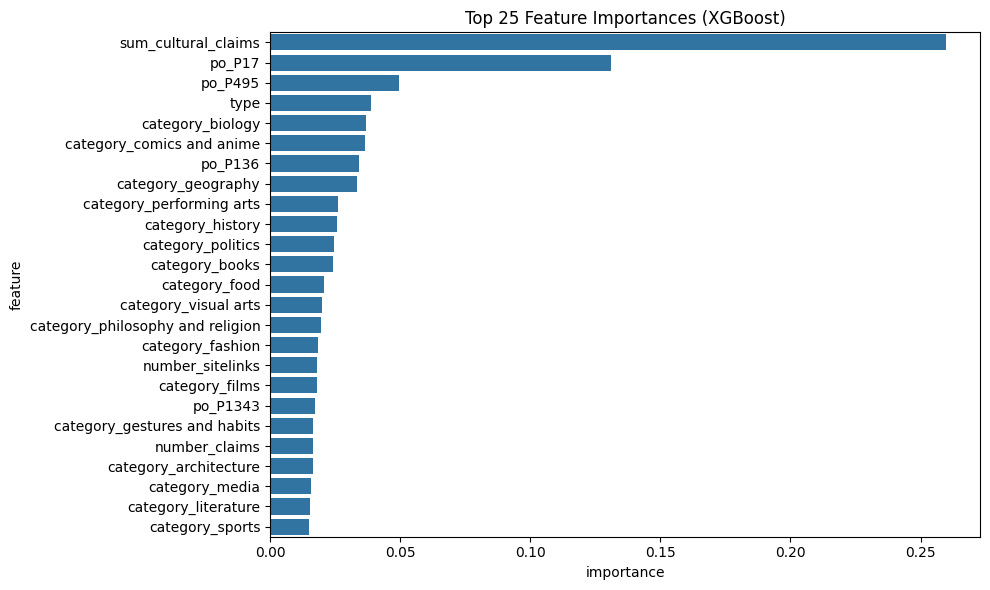

In [7]:
LABELS = ["cultural agnostic", "cultural representative", "cultural exclusive"]

def evaluate(preds, labels):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    acc = np.mean(preds == labels)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Grid Search XGBoost
print("Starting training and grid search...")
param_grid = {
    'n_estimators': [200, 250, 270],
    'max_depth': [5, 6],
    'learning_rate': [0.03, 0.05],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(objective="multi:softprob", num_class=3, use_label_encoder=False, verbosity=0)
clf = GridSearchCV(xgb, param_grid, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

print(f"Best parameters: {clf.best_params_}")

# Retrain best model
best_xgb = XGBClassifier(**clf.best_params_, objective="multi:softprob", num_class=3, use_label_encoder=False, verbosity=0)
best_xgb.fit(X_train, y_train)

dev_preds = best_xgb.predict(X_val)
metrics = evaluate(dev_preds, y_val)

print("Final dev set metrics:", metrics)
# === Plotting ===
os.makedirs("nonlm_based", exist_ok=True)
cm = confusion_matrix(y_val, dev_preds, labels=[0, 1, 2], normalize="true")
df_cm = pd.DataFrame(cm, index=LABELS, columns=LABELS)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Confusion Matrix (Ultra Non-LM Based + Stacking)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig("nonlm_based/confusion_matrix_ultra_stacking.png")

# Classification Report
report = classification_report(y_val, dev_preds, target_names=LABELS, zero_division=0)
print(report)
with open("nonlm_based/classification_report_ultra_stacking.json", "w") as f:
    json.dump(classification_report(y_val, dev_preds, target_names=LABELS, output_dict=True), f, indent=2)

print("\n\u2705 Ultra Stacking Mode Completed!")

importances = best_xgb.feature_importances_
fi_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False).head(25)

plt.figure(figsize=(10,6))
sns.barplot(data=fi_df, x='importance', y='feature')
plt.title("Top 25 Feature Importances (XGBoost)")
plt.tight_layout()
plt.savefig("nonlm_based/feature_importances_xgb.png")
plt.show()

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, ConfusionMatrixDisplay)

In [57]:
train_probs = best_xgb.predict_proba(X_train)
val_probs = best_xgb.predict_proba(X_val)

In [58]:
try:
  train_aug = pd.read_csv('train_augmented.csv')
  valid_aug = pd.read_csv('valid_augmented.csv')
  print("Caricati DataFrame con feature aggiuntive.")
except Exception as e:
  print(f"Errore durante il caricamento del file train_augmented.csv: {e}")

train_aug.columns.tolist()

Caricati DataFrame con feature aggiuntive.


['item',
 'name',
 'type',
 'category',
 'subcategory',
 'label',
 'title',
 'page_length',
 'num_links',
 'mean_sitelinks_count',
 'median_sitelinks_count',
 'std_sitelinks_count']

In [59]:
train_aug_aligned = train_aug.reindex(X_train.index)
valid_aug_aligned = valid_aug.reindex(X_val.index)
print(f"\nShape train_aug_aligned dopo reindex: {train_aug_aligned.shape}")
print(f"\nShape train_aug_aligned dopo reindex: {valid_aug_aligned.shape}")


Shape train_aug_aligned dopo reindex: (6249, 12)

Shape train_aug_aligned dopo reindex: (300, 12)


In [60]:
if X_train.index.equals(train_aug_aligned.index):
    print("Verifica ok.")
else:
    print("errore indici non corrispondono")

Verifica ok.


In [61]:
train_aug_process = train_aug_aligned.drop(columns=['item', 'name', 'type', 'category', 'subcategory', 'label', 'title'])
valid_aug_process = valid_aug_aligned.drop(columns=['item', 'name', 'type', 'category', 'subcategory', 'label', 'title'])

In [62]:
train_aug_process.columns.tolist()

['page_length',
 'num_links',
 'mean_sitelinks_count',
 'median_sitelinks_count',
 'std_sitelinks_count']

In [63]:
train_aug_process = train_aug_process.values.astype(np.float32)
valid_aug_process = valid_aug_process.values.astype(np.float32)

In [88]:
scaler = StandardScaler()
train_aug_process = scaler.fit_transform(train_aug_process)
valid_aug_process  = scaler.transform(valid_aug_process)

In [89]:
X_meta_train = np.hstack([train_probs.astype(np.float32), train_aug_process])
X_meta_val = np.hstack([val_probs.astype(np.float32), valid_aug_process])

In [90]:
X_train_tensor = torch.tensor(X_meta_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_meta_val, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

In [91]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [131]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [133]:
class MetaLearner(nn.Module):
    def __init__(self, num_features, num_classes,
                 h1=256, h2=128, h3=64, h4=32,  # Unità per layer (esempio)
                 drop1=0.4, drop2=0.2, drop3=0.1, drop4=0.1): # Tassi di Dropout
        super().__init__()
        self.layer_stack = nn.Sequential(
            # Layer 1
            nn.Linear(num_features, h1),
            nn.ReLU(),
            nn.BatchNorm1d(h1), # Aggiunta Batch Normalization (spesso utile in reti più profonde)
            nn.Dropout(drop1),

            # Layer 2
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.BatchNorm1d(h2),
            nn.Dropout(drop2),

            # Layer 3
            nn.Linear(h2, h3),
            nn.ReLU(),
            nn.BatchNorm1d(h3),
            nn.Dropout(drop3),

            # Layer 4

            nn.Linear(h3, h4),
            nn.ReLU(),
            nn.BatchNorm1d(h4),
            nn.Dropout(drop4 * 0.5),

            nn.Linear(h4, num_classes)
        )

    def forward(self, x):
        logits = self.layer_stack(x)
        return logits

input_features = X_train_tensor.shape[1]
output_classes = y_train_tensor.unique().shape[0]

model = MetaLearner(input_features, output_classes)
print(f"Model structure: {model}\n\n")
total_params = sum(p.numel() for p in model.parameters())
print(f"Numero totale di parametri: {total_params}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Addestramento su dispositivo: {device}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

print("\n--- Inizio Addestramento (Rete Più Profonda) ---")
num_epochs = 50

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
start_train_time = time.time()

# --- Implementazione Early Stopping  ---
patience = 15  # Quante epoche aspettare senza miglioramenti della val_loss
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None # Per salvare i pesi del modello migliore

print(f"Early Stopping attivato con patience={patience}")
# ---------------------------------------------------------------------


for epoch in range(num_epochs):
    # --- Fase di Training  ---
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Fase di Validazione ---
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoca [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')


    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Salva lo stato del modello corrente come il migliore finora
        best_model_state = model.state_dict()
        print(f"  Nuova miglior val_loss: {best_val_loss:.4f}. Salvataggio modello...")
    else:
        epochs_no_improve += 1
        print(f"  Val_loss non migliorata per {epochs_no_improve} epoche.")

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping attivato all'epoca {epoch+1} dopo {patience} epoche senza miglioramenti.")
        break

# --- Fine Ciclo Addestramento ---

end_train_time = time.time()
print(f"\nAddestramento interrotto/completato in {(end_train_time - start_train_time):.2f} secondi.")

# --- Carica i pesi del modello migliore trovato da Early Stopping ---
if best_model_state is not None:
    print("Caricamento dei pesi del modello con la migliore validation loss...")
    model.load_state_dict(best_model_state)
else:
     print("Attenzione: Early stopping non attivato o nessun modello salvato. Si usa l'ultimo modello.")
# --- 5. Valutazione Finale e Metriche (come prima) ---
print("--- Valutazione Finale su Validation Set ---")

Model structure: MetaLearner(
  (layer_stack): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.05, inplace=False)
    (16): Linear(in_features=32, out_features=3, bias=True)
  )
)


Numero totale di parametri: 46595
Addestramen


Metriche PyTorch DNN sul Validation Set:
  Accuracy:        0.7600
  Precision (macro): 0.7523
  Recall (macro):    0.7581
  F1-Score (macro): 0.7517

Confusion Matrix PyTorch DNN:


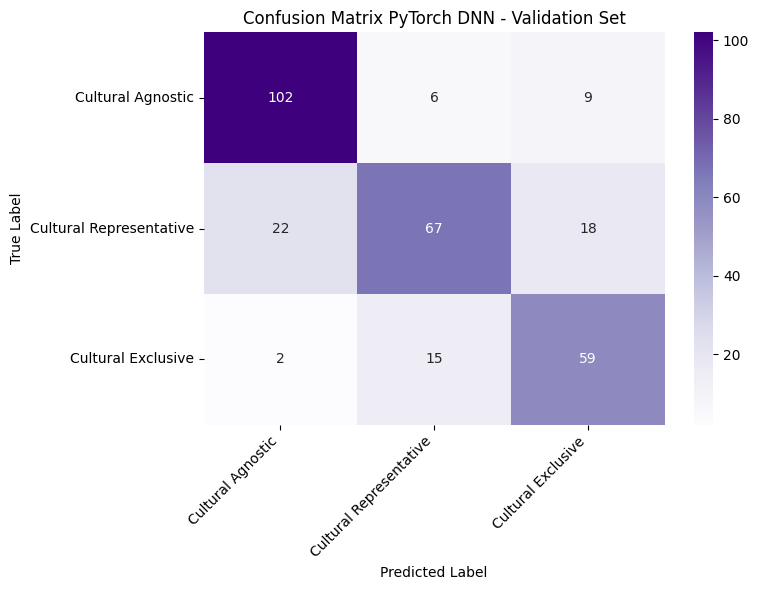

------------------------------
Valutazione e plotting completati.


In [134]:
# Raccogli predizioni e label vere
all_val_preds = []
all_val_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_val_preds.extend(predicted.cpu().numpy())
        all_val_labels.extend(labels.numpy()) # Prende le labels originali dal loader

y_pred_val_nn = np.array(all_val_preds)
y_val_true = np.array(all_val_labels)


# Calcola metriche
accuracy_nn = accuracy_score(y_val_true, y_pred_val_nn)
average_strategy = 'macro'
precision_nn = precision_score(y_val_true, y_pred_val_nn, average=average_strategy, zero_division=0)
recall_nn = recall_score(y_val_true, y_pred_val_nn, average=average_strategy, zero_division=0)
f1_nn = f1_score(y_val_true, y_pred_val_nn, average=average_strategy, zero_division=0)

print("\nMetriche PyTorch DNN sul Validation Set:")
print(f"  Accuracy:        {accuracy_nn:.4f}")
print(f"  Precision ({average_strategy}): {precision_nn:.4f}")
print(f"  Recall ({average_strategy}):    {recall_nn:.4f}")
print(f"  F1-Score ({average_strategy}): {f1_nn:.4f}")
print("\nConfusion Matrix PyTorch DNN:")
class_names = ['Cultural Agnostic', 'Cultural Representative', 'Cultural Exclusive']
cm_nn = confusion_matrix(y_val_true, y_pred_val_nn)
plt.figure(figsize=(8, 6))
plot_labels = class_names if class_names is not None else 'auto'
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples',
            xticklabels=plot_labels, yticklabels=plot_labels)
plt.title('Confusion Matrix PyTorch DNN - Validation Set')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
if class_names: plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

print("-" * 30)
print("Valutazione e plotting completati.")